In [1]:
# MISC
import os
import sys
%load_ext autoreload 

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import shutup
shutup.please()

import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import functools

# RL 
import gymnasium
import flashbax as fbx

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [11]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze())
test.reset()
img = test.render(return_img=True) 

In [27]:
test.maze.maze_grid

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

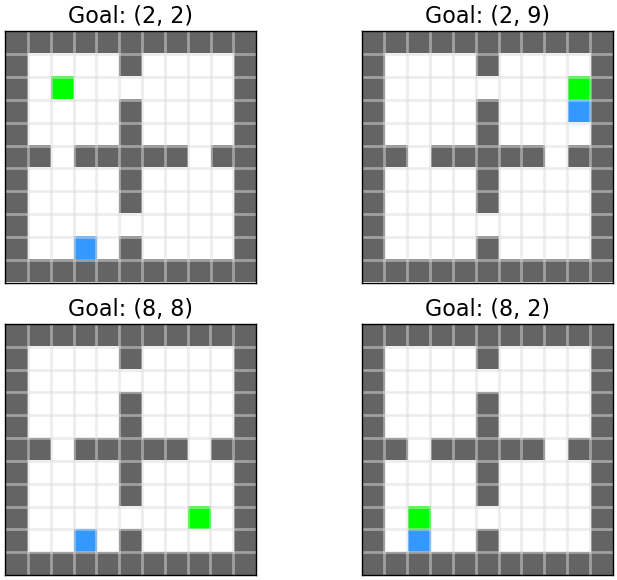

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

# Data Collection for Maze

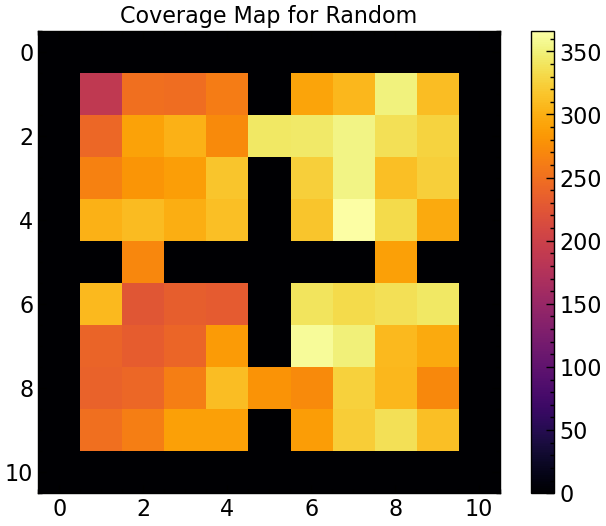

  0%|          | 0/200 [00:00<?, ?it/s]

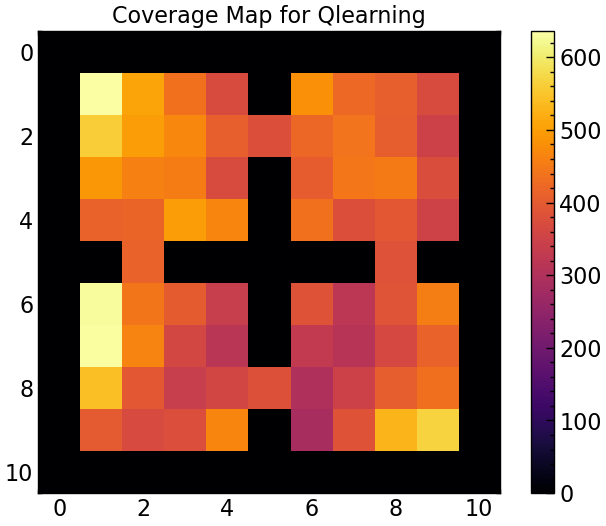

In [ ]:
def random_exploration(env, num_episodes=100, num_steps=200):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []

    for _ in range(num_episodes):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        while i < num_steps:
            i+=1
            cur_observations.append(np.array(state, dtype=np.float32))
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    
    # # Normalize
    # dataset['observations'] /= np.array(env.maze.size, dtype=np.float32)
    # dataset['next_observations'] /= np.array(env.maze.size, dtype=np.float32)
    return coverage_map, dataset

def q_learning(env, num_episodes=200, horizon_T=200, alpha=0.1, gamma=0.99, epsilon=0.5):
    Q = np.zeros((env.maze.size[0], env.maze.size[1], env.action_space.n))
    coverage_map = np.where(env.maze_state == 1, -1000, env.maze_state)
    dataset = dict()
    observations = []
    actions = []
    dones = []
    
    for _ in tqdm(range(num_episodes), colour='green', leave=False):
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        done = False
        step = 0
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        #for j in range(horizon_T):
        while not done:
            cur_observations.append(np.array(state, dtype=np.float32))
            if (np.random.rand() < epsilon) or step < 100:# and j < 50:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state[0], state[1], :])
            
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
            
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            step+=1
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    
    return coverage_map, dataset

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

# Example usage
env = FourRoomsMazeEnv(Maze())
coverage_map_random, dataset_random = random_exploration(env)
visualize_coverage_map(coverage_map_random, name='Random')

coverage_map_q_learning, dataset_q_learning = q_learning(env)
visualize_coverage_map(coverage_map_q_learning, name='Qlearning')

In [7]:
from utils.datasets import Dataset

whole_data = jax.tree.map(
    lambda x, y: jnp.concatenate([x, y]), dataset_random, dataset_q_learning
)
np.save("../aux_data/fourroom_data", arr=jax.device_get(whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

In [8]:
from utils.datasets import GCDataset
import sys
sys.path.append("..")

from agents.fb import get_config, ForwardBackwardAgent

fb_discrete_config = get_config()
fb_discrete_config.discrete = True
gc_whole_dataset = GCDataset(whole_dataset, config=fb_discrete_config)

fb_agent = ForwardBackwardAgent.create(
    42,
    env.observation_space.sample()[None, :],
    np.full(shape=(1, 2), fill_value=env.action_space.n - 1),
    config=fb_discrete_config
)
# fb_agent.update(gc_whole_dataset.sample(64))

2025-02-24 19:01:06.107078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740412866.129464  378604 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740412866.136360  378604 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


E0224 19:01:14.778423  378604 pjrt_stream_executor_client.cc:3045] Execution of replica 0 failed: INTERNAL: the library was not initialized


XlaRuntimeError: INTERNAL: the library was not initialized

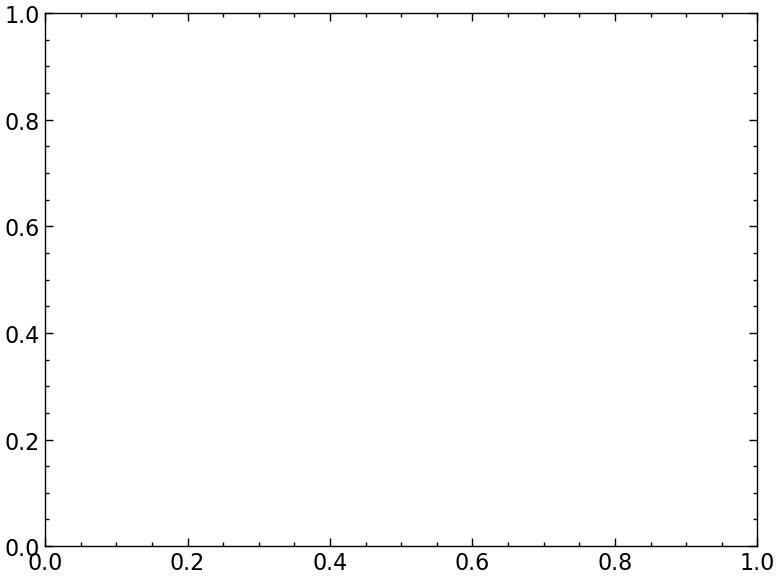

In [9]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

example_batch = gc_whole_dataset.sample(1)
observation, info = test.reset(options=dict(task_id=2, render_goal=True))
goal = info.get('goal_pos')
start = test.start
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = test.maze.size
latent_z = np.tile(latent_z, (N * M, 1))
pred_value_img = value_image_fourrooms(test, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)